In [6]:
!cd .. && git submodule init
!cd .. && git submodule update
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake\
  -DPYTHON_EXECUTABLE="$(which python3)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: no se puede crear el directorio «build»: El archivo ya existe
-- The C compiler identification is GNU 7.4.0
-- The CXX compiler identification is GNU 7.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /usr/bin/python3 (found version "3.6.8") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.6m.so
-- pybind11 v2.3.dev0
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/romina/Escritorio/Metodos/metodos-tp3
-- Configuring done
-- Gene

In [7]:
import linearregression
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import time
import math
import calendar
import datetime
import matplotlib.dates as mdates
import sys
import pickle

In [8]:
def outliers_cuartil(df):
    q1 = df["Delay"].quantile(0.25)
    q3 = df["Delay"].quantile(0.75)
    d = q3-q1
    df = df[df.Delay > q1+d*1.5]
    df = df[df.Delay < q3-d*1.5]
    return df

In [9]:
def cross_validation(df,label_x,label_y,particiones,funcion,grado):
    particion_anterior = 0
    diferencias = []
    tam_particion = int(df[label_x].count()/particiones)
    for i in range(particiones):
        if i != particiones-1:
            particion = int(df[label_x].count()/particiones)*(i+1)
            #data_train  = df[label_x][:particion]
            data_train = df.index[:particion]
            #data_test   = df[label_x][particion:particion+tam_particion]
            data_test   = df.index[particion:particion+tam_particion]
            label_train = df[label_y][:particion]
            label_test  = df[label_y][particion:particion+tam_particion]
            particion_anterior = particion
            tp3 = linearregression.CuadradosMinimos(funcion)
            tp3.fit(grado, data_train, label_train)
            ys = tp3.predict(data_test)            
            diferencias.append(sum((ys-label_test)**2))
        #el ultimo se tiene que descartar porque por como agarro las particiones la ultima se compararia a si
        #misma ABS
    RMSE = (sum(diferencias)/(particiones-1))**(1./2)
    return RMSE

In [10]:
def cross_validation_fusion(df,label_x,label_y,particiones,funcion,grado,pi):
    particion_anterior = 0
    diferencias = []
    tam_particion = int(df[label_x].count()/particiones)
    for i in range(particiones):
        if i != particiones-1:
            particion = int(df[label_x].count()/particiones)*(i+1)
            #data_train  = df[label_x][:particion]
            data_train = df.index[:particion]
            #data_test   = df[label_x][particion:particion+tam_particion]
            data_test   = df.index[particion:particion+tam_particion]
            label_train = df[label_y][:particion]
            label_test  = df[label_y][particion:particion+tam_particion]
            particion_anterior = particion
            tp3 = linearregression.CuadradosMinimos(funcion)
            tp3.fit_fusion(grado,pi, data_train, label_train)
            ys = tp3.predict(data_test)            
            diferencias.append(sum((ys-label_test)**2))
        #el ultimo se tiene que descartar porque por como agarro las particiones la ultima se compararia a si
        #misma ABS
    RMSE = (sum(diferencias)/(particiones-1))**(1./2)
    return RMSE

In [11]:
def entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion,familia):
    #yolo
    particiones = 4
    if familia != 'fusion':
        regr = linearregression.CuadradosMinimos(familia)
        df_entrenamiento = df[df.index.isin(rango_entrenamiento)]    
        xi =df_entrenamiento.index.values.astype(float)
        # 'Fiteo' los datos de entrenamiento
        grado = 0
        min_rmse = cross_validation(df,'Month','Delay',particiones,familia,grado)
        mejor_grado = 0
        if familia == 'pol':
            while grado <= 20:
                rmse = cross_validation(df,'Month','Delay',particiones,familia,grado)
                grado += 1
                if min_rmse > rmse:
                    min_rmse = rmse
                    mejor_grado = grado
            print(mejor_grado, min_rmse)
        else:
            while grado < 20:
                rmse = cross_validation(df,'Month','Delay',particiones,familia,grado*math.pi)
                grado += 0.01                
                if min_rmse > rmse:
                    min_rmse = rmse
                    mejor_grado = grado*math.pi
            print(mejor_grado/math.pi, min_rmse)
        regr.fit(mejor_grado,xi, df_entrenamiento['Delay'])
        df_entrenamiento['pred'] = regr.predict(xi)
        ax.plot(df_entrenamiento.index.values, df_entrenamiento['pred'],'r-')
        ## Realizo predicciones
        df_prediccion = df[df.index.isin(rango_prediccion)]
        xs = df_prediccion.index.values.astype(float)
        # Predigo los datos de testeo
        df_prediccion['pred'] = regr.predict(xs)
        # Grafico la prediccion
        ax.plot(df_prediccion.index.values, df_prediccion['pred'], 'g-')

        ## Calculo el Error Cuadrático Mediodf_prediccion['y'
        ECM = ((df_prediccion['pred'] - df_prediccion['Delay'])**2).mean()
        print(xs)
        print(regr.predict(xs))
        return ECM
    else:
        regr = linearregression.CuadradosMinimos(familia)
        df_entrenamiento = df[df.index.isin(rango_entrenamiento)]    
        xi =df_entrenamiento.index.values.astype(float)
        # 'Fiteo' los datos de entrenamiento
        grado = 0
        pi = 0
        min_rmse = cross_validation_fusion(df,'Month','Delay',particiones,familia,grado,pi*math.pi)
        mejor_grado = 0
        mejor_pi = 0
        while grado <= 5:
            pi = 0
            while pi < 2:
                rmse = cross_validation_fusion(df,'Month','Delay',particiones,familia,grado,pi*math.pi)
                if min_rmse > rmse:
                    min_rmse = rmse
                    mejor_grado = grado
                    mejor_pi = pi
                pi += 0.01
            grado +=1
        print(mejor_grado,mejor_pi/math.pi, min_rmse)
        regr.fit_fusion(mejor_grado,mejor_pi*math.pi,xi, df_entrenamiento['Delay'])
        df_entrenamiento['pred'] = regr.predict(xi)
        ax.plot(df_entrenamiento.index.values, df_entrenamiento['pred'],'r-')
        ## Realizo predicciones
        df_prediccion = df[df.index.isin(rango_prediccion)]
        xs = df_prediccion.index.values.astype(float)
        # Predigo los datos de testeo
        df_prediccion['pred'] = regr.predict(xs)
        # Grafico la prediccion
        ax.plot(df_prediccion.index.values, df_prediccion['pred'], 'g-')

        ## Calculo el Error Cuadrático Mediodf_prediccion['y'
        ECM = ((df_prediccion['pred'] - df_prediccion['Delay'])**2).mean()
        return ECM
        

def predecir(k,familia):
    rango_entrenamiento =(df.index[0:k+1] )    
    rango_prediccion = (df.index[k:k+12] )
    return entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion,familia)

0 0.1591549430918954 8233280.495796375


/home/romina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/romina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Error de predicción: 5339564495296.95


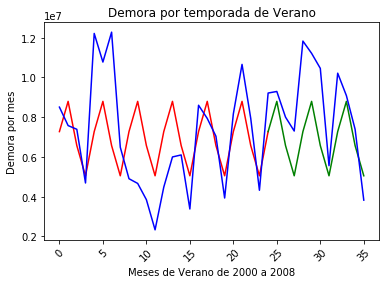

In [12]:
df = pd.read_csv('prueba.csv', encoding='latin-1')
ig, ax= plt.subplots()
ECM = predecir(24,'fusion')
print("Error de predicción: {:.2f}".format(ECM))
ax.plot(df.index.values, 
        df['Delay'], 
        color = 'blue')
# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45)

# set title and labels for axes
ax.set(xlabel="Meses de Verano de 2000 a 2008",
       ylabel="Demora por mes",
       title="Demora por temporada de Verano");
plt.show()

1 0.04456338406573069 11879194.73709082
Error de predicción: 10201836200868.53


/home/romina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/romina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


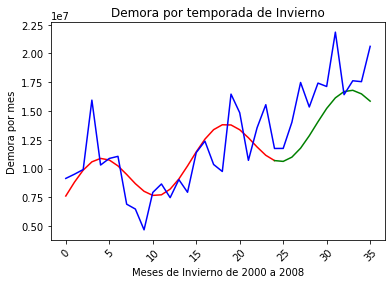

In [13]:
df = pd.read_csv('prueba2.csv', encoding='latin-1')
ig, ax= plt.subplots()

ECM = predecir(24,'fusion')
print("Error de predicción: {:.2f}".format(ECM))
ax.plot(df.index.values, 
        df['Delay'], 
        color = 'blue')
# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45)

# set title and labels for axes
ax.set(xlabel="Meses de Invierno de 2000 a 2008",
       ylabel="Demora por mes",
       title="Demora por temporada de Invierno");
plt.show()